## Manuscript Figure 2 - SNARE-seq

I. [Comparing correlation of single-cell and pseudo-bulk data](#f2b)  

II. The graph-based correlation avoids potential false positives by two strategy:  
   1. It cares about graph dependence of features, lower the value of pairs not enriched in the graph  
        a. [L and Pearson's r behavior in the whole dataset](#f2c1)  
        b. [L and Pearson's r behavior in one or few clusters](#f2c2)  
        c. [L and Pearson's r behavior in false positives](#f2d)  
   2. It poses single-cell-specific significance test   
        a. [Calculate p values in the two methods](#f2e)


In [1]:
import os
os.environ['OPENBLAS_NUM_THREADS'] = '20'
import sys
sys.path.append('../')

import numpy as np
import pandas as pd
import scanpy as sc
import anndata as ad
import scipy as sp
#import colorcet as cc
import matplotlib.pyplot as plt
import libpysal as lps
import random
from matplotlib import rcParams
import seaborn as sns
import time
sc.set_figure_params(
    scanpy=True, dpi_save=600, vector_friendly=True, format="pdf",
    facecolor=(1.0, 1.0, 1.0, 0.0), transparent=False
)
rcParams["savefig.bbox"] = "tight"

/mnt/atlas_local/chaozhong/home/miniconda3/envs/multiome/lib/python3.10/site-packages/libpysal/weights/util.py:23: UserWarning: geopandas not available. Some functionality will be disabled.
  warn("geopandas not available. Some functionality will be disabled.")


### Comparing correlation of single-cell and pseudo-bulk data  <a name="f2b"></a>

In [2]:
# Load single-cell and pseudo-bulk data
ad_pb_all = ad.read_h5ad('../data/snare_seq/SNARE_mousebrain.all.pseudo.h5ad')
ad_sc_all = ad.read_h5ad('../data/snare_seq/SNARE_mousebrain.all.sc.h5ad')

# select the nearest peaks upstream of each gene
peaks_nearby = ad_pb_all.uns['peaks_nearby'].copy()
peaks_nearby = peaks_nearby.loc[peaks_nearby['tss_dist']<=0].sort_values('tss_dist', ascending=False)
peaks_nearby = peaks_nearby.loc[~peaks_nearby['genes'].duplicated()]
peaks_nearby = peaks_nearby.loc[peaks_nearby['tss_dist']>=-20000]

ad_pb_all.uns['peaks_nearby'] = peaks_nearby.copy()
ad_sc_all.uns['peaks_nearby'] = peaks_nearby.copy()

In [3]:
# calculate L and r
import multiome.graph_measure as graph_measure
ad_pb_all = graph_measure.Global_L(ad_pb_all, permutations=0)
ad_pb_all = graph_measure.Global_Pearson(ad_pb_all, p_value=False)

ad_sc_all = graph_measure.Global_L(ad_sc_all, permutations=0)
ad_sc_all = graph_measure.Global_Pearson(ad_sc_all, p_value=False)


Calculating global graph-based correlation value...
Following changes made to the AnnData object:
	Global L results and QC metrics updated in uns['peaks_nearby'].
Calculating Pearson's correlation coefficient...
Following changes made to the AnnData object:
	Pearson Correlation results saved in uns['peaks_nearby']
Calculating global graph-based correlation value...
Following changes made to the AnnData object:
	Global L results and QC metrics updated in uns['peaks_nearby'].
Calculating Pearson's correlation coefficient...
Following changes made to the AnnData object:
	Pearson Correlation results saved in uns['peaks_nearby']


In [4]:
peaks_nearby_sc = ad_sc_all.uns['peaks_nearby'].copy()
peaks_nearby_pb = ad_pb_all.uns['peaks_nearby'].copy()


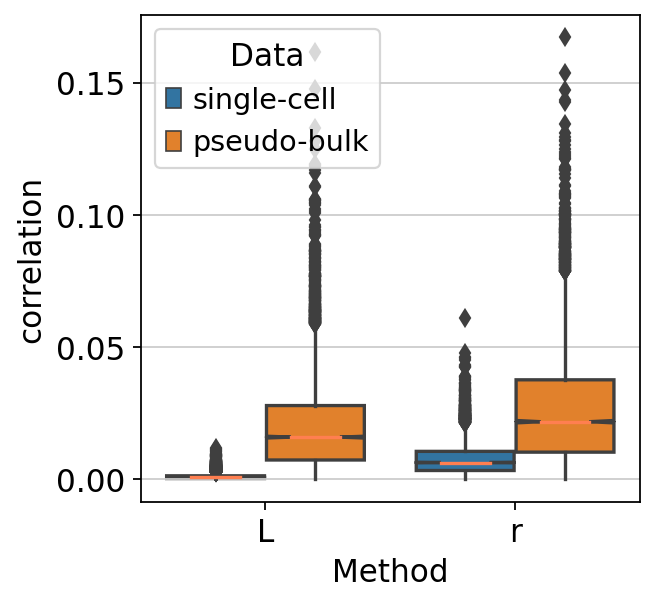

In [5]:
promoter_cor = pd.DataFrame({'correlation': peaks_nearby_sc['L'].abs().tolist() + peaks_nearby_sc['r'].abs().tolist() + \
                            peaks_nearby_pb['L'].abs().tolist() + peaks_nearby_pb['r'].abs().tolist(),
                            'Data': ['single-cell']*peaks_nearby_sc.shape[0]*2 + ['pseudo-bulk']*peaks_nearby_pb.shape[0]*2,
                            'Method':np.tile(np.repeat(['L'],peaks_nearby_sc.shape[0]).tolist() + np.repeat(['r'],peaks_nearby_sc.shape[0]).tolist(),2)})

ax = sns.boxplot(
    data=promoter_cor, x="Method", y='correlation',
    notch=True, showcaps=False,
    hue="Data",
    #flierprops={"marker": "x"},
    #boxprops={"facecolor": (.4, .6, .8, .5)},
    medianprops={"color": "coral"},
)
#ax.set_ylim([0, 0.2])   

In [6]:
promoter_cor['dataset'] = 'SNARE-seq'
promoter_cor.to_csv('results/SNARE_mousebrain.sc_vs_pseudo.csv',index=False)

### L and Pearson's r behavior in the whole dataset <a name="f2c1"></a>

In [2]:
# Calculate Moran's I
import multiome.graph_measure as graph_measure
ad_pb_all = ad.read_h5ad('../data/snare_seq/SNARE_mousebrain.all.pseudo.h5ad')
ad_pb_all = graph_measure.Morans_I(ad_pb_all)

/mnt/atlas_local/chaozhong/home/miniconda3/envs/multiome/lib/python3.10/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  warnings.warn(message)


Following changes made to the AnnData object:
	Moran's I value saved in var['Morans.I']
42.356s past


In [3]:
# Calculate L and r
peaks_nearby = ad_pb_all.uns['peaks_nearby'].copy()
peaks_nearby = peaks_nearby.loc[peaks_nearby['tss_dist']<=0].sort_values('tss_dist', ascending=False)
peaks_nearby = peaks_nearby.loc[~peaks_nearby['genes'].duplicated()]
peaks_nearby = peaks_nearby.loc[peaks_nearby['tss_dist']>=-20000]
ad_pb_all.uns['peaks_nearby'] = peaks_nearby.copy()

ad_pb_all = graph_measure.Global_L(ad_pb_all, permutations=0)
ad_pb_all = graph_measure.Global_Pearson(ad_pb_all, p_value=False)


Calculating global graph-based correlation value...
Following changes made to the AnnData object:
	Global L results and QC metrics updated in uns['peaks_nearby'].
Calculating Pearson's correlation coefficient...
Following changes made to the AnnData object:
	Pearson Correlation results saved in uns['peaks_nearby']


In [4]:
peaks_nearby = ad_pb_all.uns['peaks_nearby'].copy()
peaks_nearby['MoranI.gene'] = ad_pb_all.var.loc[peaks_nearby['genes'].to_numpy(),'Morans.I'].to_numpy()

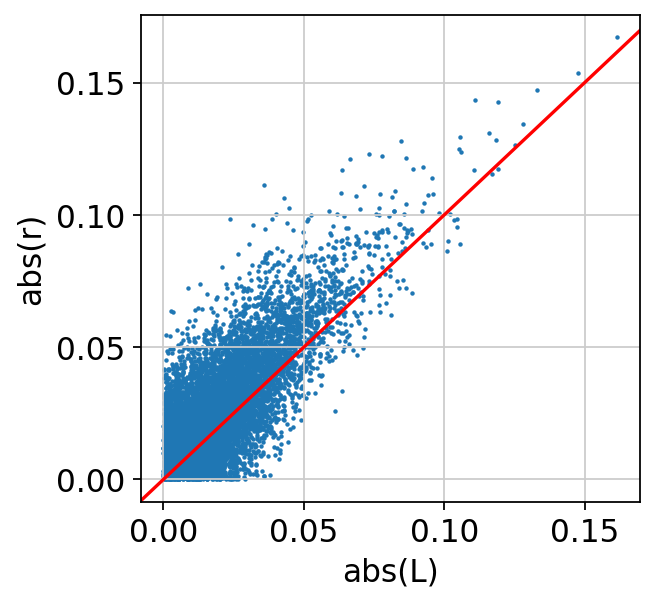

In [5]:
peaks_nearby['absL'] = peaks_nearby['L'].abs()
peaks_nearby['absr'] = peaks_nearby['r'].abs()

peaks_nearby.plot.scatter(x='absL',
                          y='absr',
                          #c='MoranI.gene',
                          s=1)
plt.xlabel("abs(L)")
plt.ylabel("abs(r)")
plt.axline((0, 0), slope=1, color='r')
plt.savefig('plots/figure2B3.pdf',dpi=300)
plt.show()

In [6]:
sp.stats.pearsonr(peaks_nearby['absL'],peaks_nearby['absr'])

PearsonRResult(statistic=0.7677281795632905, pvalue=0.0)

### L and Pearson's r behavior in one or few clusters <a name="f2c2"></a>

In [2]:
# Calculate Moran's I
import multiome.graph_measure as graph_measure
ad_pb_ct = ad.read_h5ad('../data/snare_seq/SNARE_mousebrain.2.pseudo.h5ad')
ad_pb_ct = graph_measure.Morans_I(ad_pb_ct)

Following changes made to the AnnData object:
	Moran's I value saved in var['Morans.I']
9.986s past


In [3]:
# Calculate L and r
peaks_nearby = ad_pb_ct.uns['peaks_nearby'].copy()
peaks_nearby = peaks_nearby.loc[peaks_nearby['tss_dist']<=0].sort_values('tss_dist', ascending=False)
peaks_nearby = peaks_nearby.loc[~peaks_nearby['genes'].duplicated()]
peaks_nearby = peaks_nearby.loc[peaks_nearby['tss_dist']>=-20000]

ad_pb_ct.uns['peaks_nearby'] = peaks_nearby.copy()

ad_pb_ct = graph_measure.Global_L(ad_pb_ct, permutations=0)
ad_pb_ct = graph_measure.Global_Pearson(ad_pb_ct, p_value=False)


Calculating global graph-based correlation value...
Following changes made to the AnnData object:
	Global L results and QC metrics updated in uns['peaks_nearby'].
Calculating Pearson's correlation coefficient...
Following changes made to the AnnData object:
	Pearson Correlation results saved in uns['peaks_nearby']


In [4]:
peaks_nearby = ad_pb_ct.uns['peaks_nearby'].copy()
peaks_nearby['MoranI.gene'] = ad_pb_ct.var.loc[peaks_nearby['genes'].to_numpy(),'Morans.I'].to_numpy()

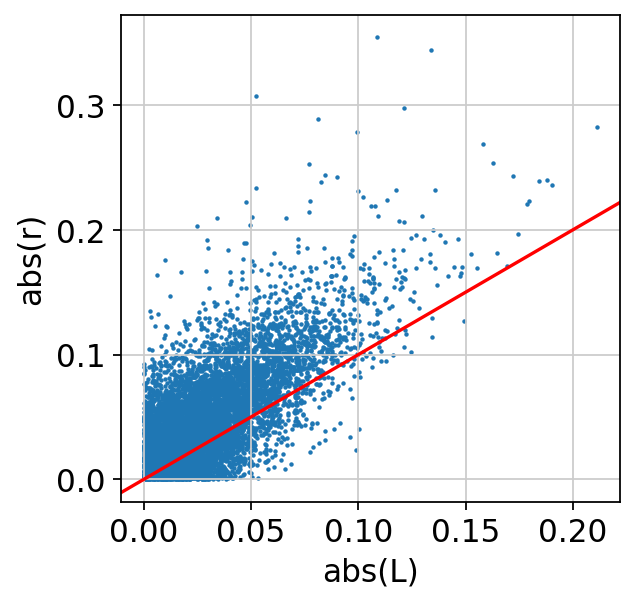

In [5]:
peaks_nearby['absL'] = peaks_nearby['L'].abs()
peaks_nearby['absr'] = peaks_nearby['r'].abs()

peaks_nearby.plot.scatter(x='absL',
                          y='absr',
                          #c='MoranI.gene',
                          s=1)

plt.xlabel("abs(L)")
plt.ylabel("abs(r)")
plt.axline((0, 0), slope=1, color='r')

In [6]:
sp.stats.pearsonr(peaks_nearby['absL'],peaks_nearby['absr'])

PearsonRResult(statistic=0.7075672667658267, pvalue=0.0)

#### L and Pearson's r behavior in false positives <a name="f2d"></a>

Mouse cell cycle gene list: https://www.genome.jp/entry/pathway+mmu04110
2: https://www.gsea-msigdb.org/gsea/msigdb/mouse/geneset/GOBP_CELL_CYCLE.html

In [8]:
ad_pb_ct = ad.read_h5ad('../data/snare_seq/SNARE_mousebrain.2.pseudo.h5ad')
cell_cycle = ['Gm1993','Gm2012','Gm2030','Gm14525','Gm20817','Gm20820','Gm16430','Gm10488','Gm10230','Prdm11','Gm4297','Rcc1','Shoc1','Phactr4','Btbd18','Mir664','Tent5b','Kifc1','Nuggc','Gm21996','Trrap','Pds5b','Mapre3','Gm21095','Gm21294','Gm29276','Gm21760','Gm28576','Hepacam2','Tada3','Ccp110','Numa1','Rrp8','Champ1','Exoc8','Gadd45gip1','Mtus1','Hinfp','Gm29866','Rnf212b','Gm28919','Gm28961','Gm28510','Gm29554','Gm28102','Gm21858','Gm28870','Bbs4','Septin10','Mbtd1','Xpo1','Fbxw11','Tubg1','Tubg2','Inca1','Tex15','Csnk1d','Meig1','E2f4','Bap1','Dgkz','Fancm','Pelo','Gm20824','Cdk20','Slf1','Exoc5','Chmp7','Scrib','Sgsm3','Mtbp','Espl1','Fbxo4','Ttbk1','Tcf19','Psmg2','Gbf1','Exoc6','Atf5','Ovol2','Mrpl41','Thoc5','Cdk9','Babam2','Cdc20','Cenpf','Camk2d','Gm21865','Gm20843','Gm20890','Gm21627','Gm20911','Gm21117','Tbcd','Nusap1','Rcc2','Cdca2','Zzz3','E2f8','Tpr','Nabp1','Uhrf2','Pimreg','Prr5','Actr5','Pkn2','Abraxas2','Kif22','Ehmt2','Triobp','Bcr','Adarb1','Fntb','Rps6ka3','Chaf1b','Ptpa','D1Pas1','M1ap','Abl1','Clic1','Tle6','Actb','Brdt','Rad51c','Acvr1','Acvr1b','Adam17','Adamts1','Adcyap1','Ahr','Aicda','Aif1','Akt1','Vps4a','Lsm10','Mta3','Alox8','Stk33','Ank3','Anxa11','Apbb1','Apbb2','Apc','Apex1','Birc3','Birc2','Xiap','Birc5','Nr2f2','App','Arf1','Arf6','Gjc2','Rhoa','Rhob','Rhoc','Arntl','Atf2','Atm','Axin2','Cep131','Bach1','Bak1','Bard1','Bax','Phb2','Bcl2','Bcl2l1','Bcl7b','Bcl7c','Bex2','Bid','Bcl2l11','Blm','Cxcr5','Bmp2','Bmp4','Bmp7','Bnip2','Bop1','Brca1','Brca2','Zfp36l1','Zfp36l2','Birc6','Btc','Btg1','Btg2','Btg3','Btrc','Bub1','Bub1b','Bub3','Cacnb4','Calm1','Calm2','Calm3','Aspm','Calr','Camk2a','Camk2b','Camk2g','Capn3','Casp2','Casp3','Cast','Ctnnb1','Runx3','Rb1cc1','Ccna1','Ccna2','Ccnb2','Ccnd1','Ccnd2','Ccnd3','Ccne1','Ccne2','Ccnf','Ccng1','Ccng2','Ccni','Ccnk','Ccnt1','Cd28','Cd2ap','Cdc25a','Cdc25b','Cdc25c','Cdk1','Cdk11b','Cdc42','Cdc45','Cdc7','Cdk2','Cdk4','Cdk5','Cdk5r1','Cdk6','Cdk7','Cdkn1a','Cdkn1b','Cdkn1c','Cdkn2a','Cdkn2b','Cdkn2c','Cdkn2d','Cebpa','Cenpa','Cenpc1','Cetn3','Cfl1','Chek1','Cirbp','Cit','Clgn','Clock','Clta','Plk3','Cpeb1','Cradd','Crebbp','Cry1','Csnk2a1','Csnk2a2','Smc3','Ctbp1','Celf1','Cyp1a1','Cyp27b1','Dach1','Dapk3','Daxx','Dazl','Dctn1','Ddb1','Gadd45a','Ddit3','Ddx3x','Ddx4','Dlg1','Dmc1','Dmd','Dync1h1','Dr1','Drd2','Drd3','Drg1','E2f1','E2f3','E2f5','E4f1','Mapre1','Ect2','Edn1','Edn3','Ednra','Egf','Egfr','Eif4e','Eif4ebp1','Epb41l2','Epc1','Stx2','Epm2a','Eps8','Ercc1','Ercc2','Ercc3','Ereg','Ptprv','Esr1','Esx1','Smarcad1','Mecom','Evi5','Eya1','Smc1b','Ezh2','Wdr5','Fanca','Fap','Fem1b','Fen1','Fes','Fgf10','Fgf2','Fgf8','Fgfr1','Fgfr2','Fgfr3','Fhl1','Fhl4','Ppm1g','Smc2','Ccn2','Foxm1','Flt3l','Fnta','Fosl1','Fzd3','Fzd9','Gas1','Gas2','Gata3','Gata4','Gata6','Kat2a','Gem','Gli1','Gnai1','Gnai2','Gnai3','Rack1','Pdpn','Gpr3','Grk5','Cdca3','Haspin','Gspt2','Hcfc1','Ptpn6','Hdac3','Htt','Hells','Hes1','Foxg1','Hhex','H2ax','Hmgb1','Hmg20b','Hmga2','Nr4a1','Foxa1','Hnf4a','Hoxa13','Hpgd','Hras','Prmt2','Hspa8','Hsf1','Hspa1b','Hspa2','Hsp90ab1','Slc6a4','Hus1','Hyal1','Id2','Id3','Id4','Ier3','Igf1','Igf1r','Igf2','Il10','Il1a','Il1b','Ilk','Kpnb1','Incenp','Inha','Inhba','Cep250','Insr','Irf1','Itgb1','Cuzd1','Ajuba','Jun','Junb','Jund','Kcna5','Kif11','Kif13a','Kif2a','Kif3a','Kif3b','Kif4','Kifc5b','Kifc2','Uhmk1','Klf4','Stmn1','Lats1','Arhgef2','Lef1','Lep','Lfng','Lif','Lig1','Lig3','Limk2','Llgl1','Lmna','Lmnb1','Anxa1','Lrp5','Lrp6','Recql5','Snx18','Krtap21-1','Mfn2','Ms4a3','Usp33','Zfp369','Mad1l1','H1f8','Ccndbp1','Ascl1','Mbd4','Mcm3','Mcm2','Mcm4','Mcm5','Mcm6','Mcm7','Anapc1','Mdm1','Mdm2','Mdm4','Mecp2','Melk','Men1','Met','Foxc1','Mki67','Mlf1','Mlh1','Mnat1','Foxk1','Mns1','Mnt','Mos','Mre11a','Meis2','Cited2','Msh2','Msh5','Sik1','Msx1','Msx2','Map4','Tesmin','Muc1','Myb','Mybl1','Mybl2','Myc','Gadd45b','Myh9','Myog','Ppp1r12a','Nedd1','Septin2','Nedd9','Nek1','Nek2','Nes','Neurog1','Nf2','Nfatc1','Nfe2l1','Nin','Nkx3-1','Nr4a3','Uhrf1','Npm1','Nppc','Nras','Ddr2','Nudc','Nup62','Odf2','Orc1','Osm','Ovol1','Mybbp1a','Pafah1b1','Pax6','Pbx1','Kat2b','Pcm1','Pcna','Pcnt','Cdk16','Cdk18','Pdcd6ip','Pdgfb','Pdgfrb','Per2','Cdk14','Abcb1b','Abcb1a','Pim1','Pim2','Prkaca','Prkacb','Prkca','Prkcd','Prkce','Prkcq','Pkd1','Pkd2','Pkia','Plcb1','Plec','Plk1','Pml','Pmp22','Pms2','Septin5','Septin4','Pola1','Pole','Pou4f1','Med1','Ppp1ca','Ppp1cb','Ppp1cc','Ppp2ca','Ppp2cb','Ppp2r3d','Ppp3ca','Nup88','Prkdc','Prox1','Lgmn','Psmc3ip','Psme1','Psme2','Psme3','Pstpip1','Ptch1','Pten','Dicer1','Flna','Rspo1','Hexim1','Ptgs2','Ptp4a1','Ptpn11','Dusp1','Ptprc','Ptprk','Ripor2','Kif20a','Rad1','Rad17','Rad21','Rad23a','Rad50','Rad51','Rad51ap1','Rad51b','Rad51d','Rad54l','Rad9a','Hspa1a','Eme2','Ran','Ranbp1','Rara','Rasl2-9','Mical3','Tmprss11a','Klf11','Btg1c','Pld6','Utp14b','Rb1','Rbbp4','Rbl1','Rbl2','Rdx','Upf1','Dpf2','Bex1','Rgs2','Ralbp1','Rnf2','Rnf4','Rny1','Rny3','Rock1','Rock2','Rpa2','Rpl26','Rps6','Rps6ka2','Rrm1','Rrm2','Rtkn','Ruvbl2','Uimc1','Ncor1','Khdrbs1','Ccl12','Ccl2','Exoc4','Septin8','Sfrp1','Sgk1','Sh2b1','Siah1a','Siah2','Stil','Sin3a','Sin3b','Sipa1','Six3','Vps4b','Skil','Slc16a1','Slfn1','Smarca4','Smarcb1','Smarcc1','Sstr5','Plk2','Son','Sox15','Sox2','Sox9','Sphk1','Cetn4','Spin1','Sptbn1','Src','BC034090','Chmp6','Yeats2','Srpk2','Trim21','Dot1l','Stag1','Stag2','Stat3','Stat5a','Stat5b','Nek11','Kntc1','Eif4g1','Stk10','Stk11','Aurkc','Dis3l2','Plk4','Sde2','Aurkb','Aurka','Fanci','Cenpx','Stra8','Sirt7','Ccnb3','Stxbp4','Gen1','Suv39h1','Trp53bp2','Hace1','Sycp1','Sycp3','Ttc28','Hus1b','Mcmbp','Brcc3','Lzts1','Exoc3','Tfdp2','Fancd2','Cspp1','Zfyve26','Mapre2','Spice1','Fbxl21','Tacc3','Prdm9','Rassf4','Taf6','Tal1','Ythdf2','Map9','Tbrg1','Tbx2','Tbx3','Tet2','Tcf3','Nudt15','Vps72','Myocd','Cdk5rap2','Cdc73','Cep164','Tent4b','Chtf18','Senp6','Brinp3','Ncaph','Rab11fip3','Rassf2','Stox1','Zfp365','Cdc34','Plk5','Appl2','Dynlt1b','Cep68','Flcn','Tom1l2','Usp22','Cntrob','Chd3','Kctd11','Git1','Trp53i13','Taok1','Evi2b','Nle1','Tada2a','Kat7','Cdc27','Llgl2','Trappc12','Terf1','Terf2','Tert','Mbip','Morf4l1','Mis18bp1','Mlh3','Nek9','Tfdp1','Nrde2','Tgfa','Tgfb1','Tgfb2','Tgm1','Nup153','Cdc14b','Timeless','Timp2','Ccno','Ube2e2','Zfp503','Tasor','Wapl','Wdhd1','Dlgap5','Nr2e1','Haus4','Cenpj','Ska3','Ccar2','Tnf','Tnfaip3','Tnks','Top2a','Top2b','Top3a','Ppp1r13b','Tpd52l1','Nr2c2','Trex1','Trp53','Trp63','Trp73','Tsc2','Tsg101','Rsph1','Ttk','Tuba1a','Tuba1b','Tuba3a','Tuba4a','Tuba1c','Tubb2a','Tubb3','Tubb4a','Tubb5','Ubb','Ube2l3','Ube2i','Uba3','Ube2b','Unc119','Prap1','Usp9x','Uxt','Ezr','Washc5','Vrk1','Sun2','Ttll12','Pim3','Baz1b','Wee1','Aaas','Wfs1','Rmi2','Marf1','Klhl22','Wiz','Wnt10b','Wnt4','Wnt5a','Dctn6','Xlr','Xlr3a','Xlr3c','Slc26a8','Bag6','Ubr2','Wac','Thoc1','Rbbp8','Ino80c','Pik3c3','Apbb3','Pggt1b','Cep120','Cep76','Mapk4','Haus1','Plaat3','Ppp2r5b','Atrx','Eml3','Xpc','Smc5','Slf2','Lzts2','Afap1l2','Ywhae','Ywhah','Yy1','Dyrk3','Zbtb17','Tiprl','Rnf112','Ahctf1','Zfp207','Zpr1','Zscan21','Stradb','Ino80d','Ctdsp1','Gigyf2','Tubb4b','Zfy2','Spout1','Zic1','Nup214','Zic3','Ikzf1','Rabgap1','Epc2','Pkp4','Tlk1','Madd','Ambra1','Kif18a','Kat14','Kiz','Mylk2','Nudt6','Spg20','Ints3','Pogz','Cdc14a','Cenpe','Npr2','Shb','Haus6','Foxj3','Zmpste24','Pdik1l','Eif4g3','Crocc','Tardbp','Phf13','Haus3','Lin54','Gak','Chfr','Rad9b','Mepce','Cyp26b1','Klhl42','Zc3hc1','Ccdc61','Mark4','Wdr62','Mrgpra1','Mrgpra3','Mrgprb4','Mrgprb1','Tubgcp5','Prc1','Gdpd5','Insc','Dcun1d3','Ino80e','Pcid2','Arhgef10','Ccdc124','Ankle1','Nae1','Txnl4b','Rfwd3','Plcg2','Chmp1a','Cdk10','Spire2','Cep126','Deup1','Kank2','Septin7','Nfrkb','Usp28','Snx33','Usp3','Topbp1','Parp3','Atrip','Setd2','Dync1li1','Mrgpra4','Alms1','Phgdh','Ercc6l','Ofd1','Zc3h12d','Cdk17','Atad5','Brip1','Rpl10l','Banf1','Kcnh5','Vash1','Cdc6','Tubal3','Btn2a2','Dmtf1','Ets1','Gadd45g','Ccnb1ip1','Setdb2','Jtb','Katna1','Rxfp3','Mapk7','Nek3','Nek4','Nlrp5','Gmnc','Pebp1','Lmln','Pin1','Cib1','Psmd13','Arid1b','Morc2b','Mdc1','Ik','Fsd1','Ythdc2','Septin3','Smc1a','Spry1','Spry2','Kif20b','Ccnj','Sra1','Mcmdc2','Taf10','Brinp2','Tlk2','Tpra1','Pkhd1','Ubd','Xrn1','Exd1','Wdr76','L3mbtl1','Klhl9','E2f2','Klhl21','Stard13','Meiosin','Mrgprx2','Mrgprb2','Myo16','Mcph1','Sgo2b','Nanos3','Ankk1','Npat','Atr','Rttn','AY074887','','Cables2','Tubgcp3','Ing1','Cetn1','Cetn2','Esrrb','Map2k1','Map3k11','Map3k8','Mapk1','Mapk13','Mapk14','Mapk3','Mapk8','Nubp1','Cul3','Rps15a','Cops5','Rab11fip4','Eme1','Meioc','Ccnb1','Fam107a','Casp8ap2','Cenph','Pkmyt1','Exo1','Macroh2a1','Cntrl','Ppp2r5c','Racgap1','Rtel1','Slc9a3r1','Jade1','Zw10','Vcp','Clspn','Epb41','Spo11','Brd7','Klhl18','Rps3','Asns','Taf1','Xlr4b','Xlr5c','Prr11','Eif2ak4','Cdk15','Dbf4','Azi2','Chaf1a','Trp53bp1','Nbn','Tjp3','Skp2','Marveld1','C2cd3','Spin2c','Prpf19','Miip','Ing4','Usp39','Larp7','Trim36','Nsun2','Cep63','Reep3','Zfp385a','Mapk12','Dpf1','Iqgap1','Fbxw5','Fbxl6','Fbxl12','Foxe3','Pttg1','Bin1','Lcmt1','Hacd1','Ifnz','Rpl17','Lig4','Usp37','Cep295','Taf2','Ercc6','Terb1','Togaram2','Tacc1','Ddx11','Senp5','Cenpt','Sycp2','Phf8','Iffo1','Dna2','Usp44','Togaram1','Npm2','Ep300','Tubgcp6','Hecw2','Birc7','Tmem67','Hfm1','Taok3','Mblac1','Piwil4','Gm773','Mapk15','Trim75','Cntln','Txlng','Zfp703','Nanos2','Heca','Lemd3','Ccnjl','Spata22','Gm20736','Gm960','Hjurp','Atp2b4','Kif14','Nsl1','Crnn','Cep135','Zcwpw1','Wee2','Mrgpra6','Taok2','Brsk1','Cep44','Ccdc84','Jade3','Gm1140','Gm5168','Gm5169','Poc1b','Ankfn1','Rrm2b','Kash5','Nsfl1c','Mir16-1','Mir214','Mir26a-1','Mir26b','Mir124a-1','Tas2r102','Tas2r121','Tas2r124','','','','Mrgprb3','Mrgprb5','Mrgprb8','Iqgap3','Bex4','Smim22','Spag8','Mn1','Ccdc8','Iho1','Xlr4a','Btg1b','Fbxl7','E2f6','Ercc4','Lats2','Fbxw7','Fbxl17','Mapk6','Plpp2','Fbxl8','Fbxl3','Dmrt1','Spast','Tmod3','Stag3','Chek2','Grb14','Nasp','Rgs14','Ppp2r1a','Hnrnpu','Mcrs1','Ccnc','Rif1','Tubgcp4','Knstrn','Cdk2ap2','Pibf1','Pbk','Ppp1r10','Camk1','Anapc4','Cdca8','Septin11','Ppp2r2d','Ctdsp2','Angel2','Cdc23','Ccdc69','E2f7','Ncaph2','Zwint','Anapc16','Tspyl2','Slx4','Plrg1','Banp','Usp2','Sdcbp','Psmd10','Exoc7','Dctn3','Blcap','Insm1','Ddx39b','Tuba8','Septin9','Rab11a','Ppm1d','Cks1b','Spag5','Akap8l','Septin1','Nme6','Azin1','Ncapg','Crlf3','Fmn2','Dnmt3l','Cpsf3','Hmcn1','Tubb1','Ptpn3','Foxo4','Pde3a','Paf1','Gm5934','Gm5935','Sh3glb1','Dclre1a','Sfn','Paxip1','Msh4','Ccnl2','Rala','Btg4','Cts7','Mad2l1','Rbm38','Prpf40a','Ensa','Uchl5','Becn1','Actr8','Rassf1','Naa10','Nupr1','Anapc7','Aatf','Arl2','Mettl3','Txnip','Arl3','Fzr1','Morf4l2','Akap8','Tubd1','Dstn','Actl6a','Snd1','Ruvbl1','Pard6a','Septin6','Gsk3b','Gpr132','Ccnl1','Brinp1','Rec8','Psrc1','Insm2','Pdxp','Brd4','Smarce1','Xrcc2','Gmnn','Xlr3b','Xlr5a','Piwil2','Piwil1','Wdr12','Tacc2','Usp29','Ttyh1','Bin3','Zfp318','Pidd1','Pard6b','Rnf8','Cep295nl','Eid1','Smpd3','Wrap73','Maea','Anapc5','Rrs1','Dact1','Arpp19','Nek6','Fign','Donson','Cenpk','Fignl1','Wtap','Foxj2','Gm6121','Mcidas','Majin','Prr19','Rad54b','Cks1brt','Ankrd31','Xlr5b','Anapc15-ps','Usp51','Trim71','Sycp2l','Cables1','Yeats4','Smoc2','Ralb','Sirt2','Suv39h2','Tsc1','Pes1','Rpl23','Map3k20','Tipin','Ska2','Anapc11','Bccip','Myo19','Cks2','Inip','Rgcc','Dmap1','Ing5','Haus2','Mplkip','Cenpw','Chmp4c','Commd5','Rtf2','Sac3d1','Cdc26','Spc25','Ska1','Exoc2','Slx','Cul7','Mis18a','Mad2l1bp','Snx9','Ntmt1','Mcm8','Tex12','Ccnh','Rae1','Chmp3','Sbds','Zbed6','Actr2','Syce1l','Trim35','Mrgpra9','Mrgpra2a','Stard9','Rad21l','Chordc1','Pbrm1','Dsn1','Cdk5rap1','Nuf2','Zfp830','Khdc3','Smarcd3','Rbm7','2610002M06Rik','Pmf1','Riok2','Ndc80','Chmp1b','Lsm14a','Catsperz','Dynlt3','Mastl','Mis12','Fbxo5','Rnaseh2b','Smarca2','Rnf212','Arl8b','Cdt1','Nde1','Cinp','Pagr1a','Cltc','Stk35','Ilkap','Klhl13','Poc5','Nek10','Ccar1','Anp32b','Spc24','Ctdp1','Itgb3bp','Poldip2','Gpsm1','Cdca5','Ppp6c','Rprm','Gipc1','Fam32a','Rps27l','Tubb6','Kmt5a','Ooep','Ccny','Hormad1','Nacc2','Zwilch','Pclaf','Fam122a','Ubxn2b','Mrnip','Nop53','Pdcd2l','Smarcc2','Cntd1','Entr1','Ino80','Etaa1','Spire1','Rpl24','Rpa3','Babam1','Rpa1','Ncapd2','Steap3','Fbxl15','Nsmce2','Eml1','Sgo2a','Cgref1','Syf2','Ube2c','Arl8a','Trim37','Anln','Cgrrf1','Washc1','Chmp2b','Chmp2a','Ctc1','Mcts1','Anapc10','Anapc13','Mitd1','Nupr1l','Tcim','Cnppd1','Kmt2e','Gtpbp4','Ing2','Gins1','Ctdspl','Avpi1','Trnp1','Mapk1ip1','Bod1','Rhou','Dab2ip','Dctn2','Tfpt','Trip13','Nup37','Ttl','Fbxo7','Trim32','Ppp1r35','Aunip','Nup43','Nabp2','Cenps','Exoc1','Tunar','Cdc16','Cep85','Ino80b','2610528A11Rik','Meaf6','Smc4','Znhit1','Dpf3','Kif18b','Poc1a','Hdac8','Spdl1','Tbce','Rprd1b','Rnf167','Stambp','Pak4','Ecd','Oip5','Vcpip1','Abraxas1','3830403N18Rik','Prdm5','Cep192','Spdya','Tex19.2','D7Ertd443e','Hexim2','Septin12','Nipbl','Ints13','Dmrtc2','Ccdc57','Rcbtb1','Foxn3','Eef1aknmt','Usp19','Sfpq','Pds5a','Pnpt1','Cdc5l','Syde1','Lrrcc1','Mus81','Susd2','Klhdc3','Ing3','Ankle2','Kif23','Shcbp1l','Syce2','Efhc1','Fam83d','Mad2l2','Haus5','Epgn','Tube1','Tom1l1','Nanog','Ist1','Tdrd12','Esco2','Zfyve19','Alkbh4','Urgcp','Phf10','Sapcd2','Ush1c','Dscc1','Zbed3','Naa50','Tpx2','Seh1l','Strada','Ccpg1','Lsm11','Dusp3','Cdkn3','Mir124a-2','Mir124a-3','Mir26a-2','Pinx1','Sgo1','Rhno1','Rps6kb1','Reep4','Lin9','Cul4b','Zfp655','Tdrkh','Rint1','Sass6','Ndc1','Pard3b','Xlr4c','Hepacam','Tppp','Ccnt2','Appl1','Cenpv','Wasl','Mrgbp','1700040F15Rik','Slc25a31','Ccsap','Kif2b','Rec114','Psma8','Tex19.1','Tubb2b','Haus7','Thap1','Kif2c','Fam122c','Ddias','Asz1','Syce1','Cep55','Usp16','Actr3','Fbxl22','Katnb1','Cep97','Septin14','Tubgcp2','Cyld','Aven','Xrcc3','Mei1','Rptor','Hsf2bp','Rmi1','Specc1l','Map10','Terb2','Efhc2','Cep72','4933427D14Rik','Mau2','Brme1','Spdye4a','Tdrd9','Setmar','Meikin','Usp47','Mei4','Zbtb49','Slxl1','Meiob','Ppp1r1c','Ankrd53','Boll','Anapc15','Syce3','1700009N14Rik','1700013H16Rik','Ep400','Sgf29','Tm4sf5','Chmp4b','Pik3r4','Brsk2','Ckap5','4930447C04Rik','Senp2','Hormad2','Exoc6b','Ncapg2','Gpsm2','Pcnp','1700028K03Rik','Fbxo31','Knl1','Haus8','Clasp2','Clasp1','Mzt1','Sdccag8','Dtl','Ago4','Gper1','Jade2','Mnd1','Chmp5','Ticrr','Kdm8','Arid2','Bcl7a','Sun1','Ints7','Rab35','Myh10','Apex2','Bora','Esco1','Ube2s','Klhdc8b','Cul9','Uvrag','Brd8','Ncapd3','Eml4','Fbxo43','Cacul1','Gins3','Ecrg4','Misp','Gas2l1','Mir744','Trim39','Recql4','Cdk5rap3','BC004004','Pum1','Ckap2','Kat5','Ankrd17','Tfap4','Ndel1','Mov10l1','Tex11','Tex14','Tdrd1','Usp26','Wdr6','Pde4dip','Actl6b','Tas1r2','Smarcd2','Smarcd1','Cenpq','Phip','Usp8','Csnk1a1','Gpnmb','Pard6g','Pard3','Sirt1','Arid1a','Smarca5','Fkbp6','Prcc','Mael','Obsl1','Cdc123','Nat10','Cep152','Anapc2','Ssx2ip','Cul4a','Golga2']
#cell_cycle = ['Ccnd1','Ccnd2','Ccnd3','Cdk4','Cdk6','Rb1','Rbl1','Rbl2','Abl1','Hdac2','Hdac1','E2f1','E2f2','E2f3','E2f4','E2f5','Tfdp1','Tfdp2','Gsk3b','Tgfb1','Tgfb2','Tgfb3','Smad2','Smad3','Smad4','Myc','Zbtb17','Cdkn2a','Cdkn2b','Cdkn2c','Cdkn2d','Cdkn1b','Cdkn1c','Cdkn1a','Ccne1','Ccne2','Cdk2','Skp1','Cul1','Rbx1','Skp2','Ccna2','Ccna1','Cdc6','Cdc45','Cdc7','Dbf4','Cdk1','Ccnb1','Ccnb2','Ccnb3','Cdc25b','Cdc25c','Ywhaz','Ywhab','Ywhaq','Ywhae','Ywhah','Ywhag','Plk1','Wee1','Wee2','Pkmyt1','Ccnh','Cdk7','Anapc1','Anapc2','Cdc27','Anapc4','Anapc5','Cdc16','Anapc7','Cdc23','Anapc10','Anapc11','Cdc26','Anapc13','Anapc15','Anapc16','Cdc20','Pttg1','Espl1','Smc1b','Smc1a','Smc3','Stag2','Stag1','Rad21','Ttk','Bub1','Bub3','Bub1b','Mad1l1','Mad2l1','Mad2l2','Fzr1','Cdc14b','Cdc14a','Atr','Atm','Trp53','Chek1','Chek2','Crebbp','Ep300','Prkdc','Mdm2','Gadd45a','Gadd45b','Gadd45g','Pcna','Sfn','Cdc25a','Orc1','Orc2','Orc3','Orc4','Orc5','Orc6','Mcm2','Mcm3','Mcm4','Mcm5','Mcm6','Mcm7']
peaks_nearby = ad_pb_ct.uns['peaks_nearby'].copy()
peaks_nearby = peaks_nearby.loc[peaks_nearby['genes'].isin(cell_cycle),:]
ad_pb_ct.uns['peaks_nearby'] = peaks_nearby.copy()


In [9]:
import multiome.graph_measure as graph_measure
ad_pb_ct = graph_measure.Global_L(ad_pb_ct, permutations=0)
ad_pb_ct = graph_measure.Global_Pearson(ad_pb_ct, p_value=False)


Calculating global graph-based correlation value...
Following changes made to the AnnData object:
	Global L results and QC metrics updated in uns['peaks_nearby'].
Calculating Pearson's correlation coefficient...
Following changes made to the AnnData object:
	Pearson Correlation results saved in uns['peaks_nearby']


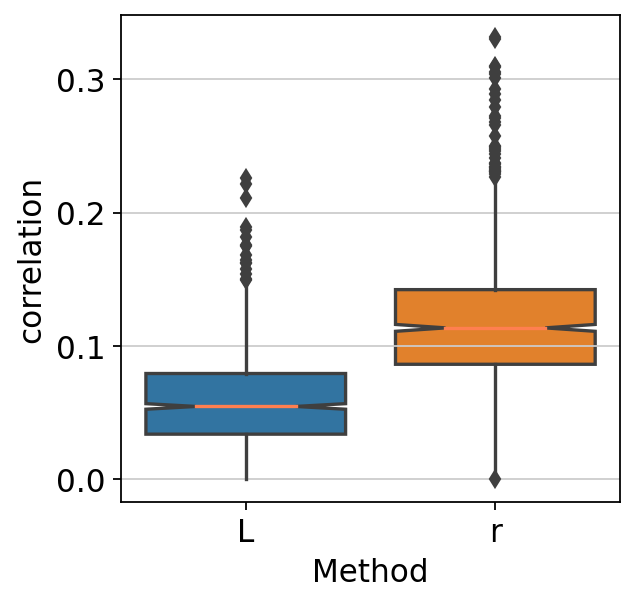

In [10]:
cc_prt = ad_pb_ct.uns['peaks_nearby'].copy() #.loc[peaks_nearby_pb['pRegion']==1]
cc_prt['absr'] = cc_prt['r'].abs()
cc_prt = cc_prt.sort_values('absr', ascending=False)
cc_prt = cc_prt.loc[~cc_prt['genes'].duplicated()]
promoter_cor = pd.DataFrame({'correlation': cc_prt['L'].abs().tolist() + cc_prt['r'].abs().tolist(),
                             'Method':np.repeat(['L'],cc_prt.shape[0]).tolist() + np.repeat(['r'],cc_prt.shape[0]).tolist()})

ax = sns.boxplot(
    data=promoter_cor, x="Method", y='correlation',
    notch=True, showcaps=False,
    #hue="Data",
    #flierprops={"marker": "x"},
    #boxprops={"facecolor": (.4, .6, .8, .5)},
    medianprops={"color": "coral"},
)
#ax.set_ylim([0, 0.2])


In [11]:
promoter_cor['dataset'] = 'SNARE-seq'
promoter_cor.to_csv('results/SNARE_mousebrain.cell_cycle.csv',index=False)

### Calculate p values in the two methods <a name="f2e"></a>

In [2]:
import multiome.graph_measure as graph_measure
ad_pb_ct = ad.read_h5ad('../data/snare_seq/SNARE_mousebrain.2.pseudo.h5ad')
ad_pb_ct

AnnData object with n_obs × n_vars = 1412 × 120568
    obs: 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'Frac.all', 'n_cells', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'means', 'dispersions', 'dispersions_norm', 'variances_norm', 'mean', 'std'
    uns: 'peaks_nearby'
    obsm: 'NN', 'X_pca', 'X_umap'
    obsp: 'connectivities', 'distances'

In [3]:
%%time
# Calculate L and r
peaks_nearby = ad_pb_ct.uns['peaks_nearby'].copy()

ad_pb_ct = graph_measure.Global_L(ad_pb_ct, permutations=999, percent=0.1)
ad_pb_ct = graph_measure.Global_Pearson(ad_pb_ct, p_value=True)
#47min

Calculating global graph-based correlation value...
Following changes made to the AnnData object:
	Global L results and QC metrics updated in uns['peaks_nearby'].
Calculating Pearson's correlation coefficient...
Calculating p-values...
Calculating FDR...
Following changes made to the AnnData object:
	Pearson Correlation results saved in uns['peaks_nearby']
CPU times: user 5h 6min 3s, sys: 41min 4s, total: 5h 47min 8s
Wall time: 49min 15s


In [4]:
peaks_nearby = ad_pb_ct.uns['peaks_nearby'].copy()
peaks_nearby.to_csv('results/SNARE_mousebrain.correlation.allpairs.csv', index=False)

In [5]:
peaks_nearby = pd.read_csv('results/SNARE_mousebrain.correlation.allpairs.csv')
peaks_nearby = peaks_nearby.loc[(peaks_nearby['tts_dist']<0) & (peaks_nearby['tts_dist']>-20000)]

peaks_nearby['-log10(L.q)'] = -np.log10(peaks_nearby['L.FDR'])
peaks_nearby['-log10(r.q)'] = -np.log10(peaks_nearby['r.FDR'])
cell_cycle = ['Gm1993','Gm2012','Gm2030','Gm14525','Gm20817','Gm20820','Gm16430','Gm10488','Gm10230','Prdm11','Gm4297','Rcc1','Shoc1','Phactr4','Btbd18','Mir664','Tent5b','Kifc1','Nuggc','Gm21996','Trrap','Pds5b','Mapre3','Gm21095','Gm21294','Gm29276','Gm21760','Gm28576','Hepacam2','Tada3','Ccp110','Numa1','Rrp8','Champ1','Exoc8','Gadd45gip1','Mtus1','Hinfp','Gm29866','Rnf212b','Gm28919','Gm28961','Gm28510','Gm29554','Gm28102','Gm21858','Gm28870','Bbs4','Septin10','Mbtd1','Xpo1','Fbxw11','Tubg1','Tubg2','Inca1','Tex15','Csnk1d','Meig1','E2f4','Bap1','Dgkz','Fancm','Pelo','Gm20824','Cdk20','Slf1','Exoc5','Chmp7','Scrib','Sgsm3','Mtbp','Espl1','Fbxo4','Ttbk1','Tcf19','Psmg2','Gbf1','Exoc6','Atf5','Ovol2','Mrpl41','Thoc5','Cdk9','Babam2','Cdc20','Cenpf','Camk2d','Gm21865','Gm20843','Gm20890','Gm21627','Gm20911','Gm21117','Tbcd','Nusap1','Rcc2','Cdca2','Zzz3','E2f8','Tpr','Nabp1','Uhrf2','Pimreg','Prr5','Actr5','Pkn2','Abraxas2','Kif22','Ehmt2','Triobp','Bcr','Adarb1','Fntb','Rps6ka3','Chaf1b','Ptpa','D1Pas1','M1ap','Abl1','Clic1','Tle6','Actb','Brdt','Rad51c','Acvr1','Acvr1b','Adam17','Adamts1','Adcyap1','Ahr','Aicda','Aif1','Akt1','Vps4a','Lsm10','Mta3','Alox8','Stk33','Ank3','Anxa11','Apbb1','Apbb2','Apc','Apex1','Birc3','Birc2','Xiap','Birc5','Nr2f2','App','Arf1','Arf6','Gjc2','Rhoa','Rhob','Rhoc','Arntl','Atf2','Atm','Axin2','Cep131','Bach1','Bak1','Bard1','Bax','Phb2','Bcl2','Bcl2l1','Bcl7b','Bcl7c','Bex2','Bid','Bcl2l11','Blm','Cxcr5','Bmp2','Bmp4','Bmp7','Bnip2','Bop1','Brca1','Brca2','Zfp36l1','Zfp36l2','Birc6','Btc','Btg1','Btg2','Btg3','Btrc','Bub1','Bub1b','Bub3','Cacnb4','Calm1','Calm2','Calm3','Aspm','Calr','Camk2a','Camk2b','Camk2g','Capn3','Casp2','Casp3','Cast','Ctnnb1','Runx3','Rb1cc1','Ccna1','Ccna2','Ccnb2','Ccnd1','Ccnd2','Ccnd3','Ccne1','Ccne2','Ccnf','Ccng1','Ccng2','Ccni','Ccnk','Ccnt1','Cd28','Cd2ap','Cdc25a','Cdc25b','Cdc25c','Cdk1','Cdk11b','Cdc42','Cdc45','Cdc7','Cdk2','Cdk4','Cdk5','Cdk5r1','Cdk6','Cdk7','Cdkn1a','Cdkn1b','Cdkn1c','Cdkn2a','Cdkn2b','Cdkn2c','Cdkn2d','Cebpa','Cenpa','Cenpc1','Cetn3','Cfl1','Chek1','Cirbp','Cit','Clgn','Clock','Clta','Plk3','Cpeb1','Cradd','Crebbp','Cry1','Csnk2a1','Csnk2a2','Smc3','Ctbp1','Celf1','Cyp1a1','Cyp27b1','Dach1','Dapk3','Daxx','Dazl','Dctn1','Ddb1','Gadd45a','Ddit3','Ddx3x','Ddx4','Dlg1','Dmc1','Dmd','Dync1h1','Dr1','Drd2','Drd3','Drg1','E2f1','E2f3','E2f5','E4f1','Mapre1','Ect2','Edn1','Edn3','Ednra','Egf','Egfr','Eif4e','Eif4ebp1','Epb41l2','Epc1','Stx2','Epm2a','Eps8','Ercc1','Ercc2','Ercc3','Ereg','Ptprv','Esr1','Esx1','Smarcad1','Mecom','Evi5','Eya1','Smc1b','Ezh2','Wdr5','Fanca','Fap','Fem1b','Fen1','Fes','Fgf10','Fgf2','Fgf8','Fgfr1','Fgfr2','Fgfr3','Fhl1','Fhl4','Ppm1g','Smc2','Ccn2','Foxm1','Flt3l','Fnta','Fosl1','Fzd3','Fzd9','Gas1','Gas2','Gata3','Gata4','Gata6','Kat2a','Gem','Gli1','Gnai1','Gnai2','Gnai3','Rack1','Pdpn','Gpr3','Grk5','Cdca3','Haspin','Gspt2','Hcfc1','Ptpn6','Hdac3','Htt','Hells','Hes1','Foxg1','Hhex','H2ax','Hmgb1','Hmg20b','Hmga2','Nr4a1','Foxa1','Hnf4a','Hoxa13','Hpgd','Hras','Prmt2','Hspa8','Hsf1','Hspa1b','Hspa2','Hsp90ab1','Slc6a4','Hus1','Hyal1','Id2','Id3','Id4','Ier3','Igf1','Igf1r','Igf2','Il10','Il1a','Il1b','Ilk','Kpnb1','Incenp','Inha','Inhba','Cep250','Insr','Irf1','Itgb1','Cuzd1','Ajuba','Jun','Junb','Jund','Kcna5','Kif11','Kif13a','Kif2a','Kif3a','Kif3b','Kif4','Kifc5b','Kifc2','Uhmk1','Klf4','Stmn1','Lats1','Arhgef2','Lef1','Lep','Lfng','Lif','Lig1','Lig3','Limk2','Llgl1','Lmna','Lmnb1','Anxa1','Lrp5','Lrp6','Recql5','Snx18','Krtap21-1','Mfn2','Ms4a3','Usp33','Zfp369','Mad1l1','H1f8','Ccndbp1','Ascl1','Mbd4','Mcm3','Mcm2','Mcm4','Mcm5','Mcm6','Mcm7','Anapc1','Mdm1','Mdm2','Mdm4','Mecp2','Melk','Men1','Met','Foxc1','Mki67','Mlf1','Mlh1','Mnat1','Foxk1','Mns1','Mnt','Mos','Mre11a','Meis2','Cited2','Msh2','Msh5','Sik1','Msx1','Msx2','Map4','Tesmin','Muc1','Myb','Mybl1','Mybl2','Myc','Gadd45b','Myh9','Myog','Ppp1r12a','Nedd1','Septin2','Nedd9','Nek1','Nek2','Nes','Neurog1','Nf2','Nfatc1','Nfe2l1','Nin','Nkx3-1','Nr4a3','Uhrf1','Npm1','Nppc','Nras','Ddr2','Nudc','Nup62','Odf2','Orc1','Osm','Ovol1','Mybbp1a','Pafah1b1','Pax6','Pbx1','Kat2b','Pcm1','Pcna','Pcnt','Cdk16','Cdk18','Pdcd6ip','Pdgfb','Pdgfrb','Per2','Cdk14','Abcb1b','Abcb1a','Pim1','Pim2','Prkaca','Prkacb','Prkca','Prkcd','Prkce','Prkcq','Pkd1','Pkd2','Pkia','Plcb1','Plec','Plk1','Pml','Pmp22','Pms2','Septin5','Septin4','Pola1','Pole','Pou4f1','Med1','Ppp1ca','Ppp1cb','Ppp1cc','Ppp2ca','Ppp2cb','Ppp2r3d','Ppp3ca','Nup88','Prkdc','Prox1','Lgmn','Psmc3ip','Psme1','Psme2','Psme3','Pstpip1','Ptch1','Pten','Dicer1','Flna','Rspo1','Hexim1','Ptgs2','Ptp4a1','Ptpn11','Dusp1','Ptprc','Ptprk','Ripor2','Kif20a','Rad1','Rad17','Rad21','Rad23a','Rad50','Rad51','Rad51ap1','Rad51b','Rad51d','Rad54l','Rad9a','Hspa1a','Eme2','Ran','Ranbp1','Rara','Rasl2-9','Mical3','Tmprss11a','Klf11','Btg1c','Pld6','Utp14b','Rb1','Rbbp4','Rbl1','Rbl2','Rdx','Upf1','Dpf2','Bex1','Rgs2','Ralbp1','Rnf2','Rnf4','Rny1','Rny3','Rock1','Rock2','Rpa2','Rpl26','Rps6','Rps6ka2','Rrm1','Rrm2','Rtkn','Ruvbl2','Uimc1','Ncor1','Khdrbs1','Ccl12','Ccl2','Exoc4','Septin8','Sfrp1','Sgk1','Sh2b1','Siah1a','Siah2','Stil','Sin3a','Sin3b','Sipa1','Six3','Vps4b','Skil','Slc16a1','Slfn1','Smarca4','Smarcb1','Smarcc1','Sstr5','Plk2','Son','Sox15','Sox2','Sox9','Sphk1','Cetn4','Spin1','Sptbn1','Src','BC034090','Chmp6','Yeats2','Srpk2','Trim21','Dot1l','Stag1','Stag2','Stat3','Stat5a','Stat5b','Nek11','Kntc1','Eif4g1','Stk10','Stk11','Aurkc','Dis3l2','Plk4','Sde2','Aurkb','Aurka','Fanci','Cenpx','Stra8','Sirt7','Ccnb3','Stxbp4','Gen1','Suv39h1','Trp53bp2','Hace1','Sycp1','Sycp3','Ttc28','Hus1b','Mcmbp','Brcc3','Lzts1','Exoc3','Tfdp2','Fancd2','Cspp1','Zfyve26','Mapre2','Spice1','Fbxl21','Tacc3','Prdm9','Rassf4','Taf6','Tal1','Ythdf2','Map9','Tbrg1','Tbx2','Tbx3','Tet2','Tcf3','Nudt15','Vps72','Myocd','Cdk5rap2','Cdc73','Cep164','Tent4b','Chtf18','Senp6','Brinp3','Ncaph','Rab11fip3','Rassf2','Stox1','Zfp365','Cdc34','Plk5','Appl2','Dynlt1b','Cep68','Flcn','Tom1l2','Usp22','Cntrob','Chd3','Kctd11','Git1','Trp53i13','Taok1','Evi2b','Nle1','Tada2a','Kat7','Cdc27','Llgl2','Trappc12','Terf1','Terf2','Tert','Mbip','Morf4l1','Mis18bp1','Mlh3','Nek9','Tfdp1','Nrde2','Tgfa','Tgfb1','Tgfb2','Tgm1','Nup153','Cdc14b','Timeless','Timp2','Ccno','Ube2e2','Zfp503','Tasor','Wapl','Wdhd1','Dlgap5','Nr2e1','Haus4','Cenpj','Ska3','Ccar2','Tnf','Tnfaip3','Tnks','Top2a','Top2b','Top3a','Ppp1r13b','Tpd52l1','Nr2c2','Trex1','Trp53','Trp63','Trp73','Tsc2','Tsg101','Rsph1','Ttk','Tuba1a','Tuba1b','Tuba3a','Tuba4a','Tuba1c','Tubb2a','Tubb3','Tubb4a','Tubb5','Ubb','Ube2l3','Ube2i','Uba3','Ube2b','Unc119','Prap1','Usp9x','Uxt','Ezr','Washc5','Vrk1','Sun2','Ttll12','Pim3','Baz1b','Wee1','Aaas','Wfs1','Rmi2','Marf1','Klhl22','Wiz','Wnt10b','Wnt4','Wnt5a','Dctn6','Xlr','Xlr3a','Xlr3c','Slc26a8','Bag6','Ubr2','Wac','Thoc1','Rbbp8','Ino80c','Pik3c3','Apbb3','Pggt1b','Cep120','Cep76','Mapk4','Haus1','Plaat3','Ppp2r5b','Atrx','Eml3','Xpc','Smc5','Slf2','Lzts2','Afap1l2','Ywhae','Ywhah','Yy1','Dyrk3','Zbtb17','Tiprl','Rnf112','Ahctf1','Zfp207','Zpr1','Zscan21','Stradb','Ino80d','Ctdsp1','Gigyf2','Tubb4b','Zfy2','Spout1','Zic1','Nup214','Zic3','Ikzf1','Rabgap1','Epc2','Pkp4','Tlk1','Madd','Ambra1','Kif18a','Kat14','Kiz','Mylk2','Nudt6','Spg20','Ints3','Pogz','Cdc14a','Cenpe','Npr2','Shb','Haus6','Foxj3','Zmpste24','Pdik1l','Eif4g3','Crocc','Tardbp','Phf13','Haus3','Lin54','Gak','Chfr','Rad9b','Mepce','Cyp26b1','Klhl42','Zc3hc1','Ccdc61','Mark4','Wdr62','Mrgpra1','Mrgpra3','Mrgprb4','Mrgprb1','Tubgcp5','Prc1','Gdpd5','Insc','Dcun1d3','Ino80e','Pcid2','Arhgef10','Ccdc124','Ankle1','Nae1','Txnl4b','Rfwd3','Plcg2','Chmp1a','Cdk10','Spire2','Cep126','Deup1','Kank2','Septin7','Nfrkb','Usp28','Snx33','Usp3','Topbp1','Parp3','Atrip','Setd2','Dync1li1','Mrgpra4','Alms1','Phgdh','Ercc6l','Ofd1','Zc3h12d','Cdk17','Atad5','Brip1','Rpl10l','Banf1','Kcnh5','Vash1','Cdc6','Tubal3','Btn2a2','Dmtf1','Ets1','Gadd45g','Ccnb1ip1','Setdb2','Jtb','Katna1','Rxfp3','Mapk7','Nek3','Nek4','Nlrp5','Gmnc','Pebp1','Lmln','Pin1','Cib1','Psmd13','Arid1b','Morc2b','Mdc1','Ik','Fsd1','Ythdc2','Septin3','Smc1a','Spry1','Spry2','Kif20b','Ccnj','Sra1','Mcmdc2','Taf10','Brinp2','Tlk2','Tpra1','Pkhd1','Ubd','Xrn1','Exd1','Wdr76','L3mbtl1','Klhl9','E2f2','Klhl21','Stard13','Meiosin','Mrgprx2','Mrgprb2','Myo16','Mcph1','Sgo2b','Nanos3','Ankk1','Npat','Atr','Rttn','AY074887','','Cables2','Tubgcp3','Ing1','Cetn1','Cetn2','Esrrb','Map2k1','Map3k11','Map3k8','Mapk1','Mapk13','Mapk14','Mapk3','Mapk8','Nubp1','Cul3','Rps15a','Cops5','Rab11fip4','Eme1','Meioc','Ccnb1','Fam107a','Casp8ap2','Cenph','Pkmyt1','Exo1','Macroh2a1','Cntrl','Ppp2r5c','Racgap1','Rtel1','Slc9a3r1','Jade1','Zw10','Vcp','Clspn','Epb41','Spo11','Brd7','Klhl18','Rps3','Asns','Taf1','Xlr4b','Xlr5c','Prr11','Eif2ak4','Cdk15','Dbf4','Azi2','Chaf1a','Trp53bp1','Nbn','Tjp3','Skp2','Marveld1','C2cd3','Spin2c','Prpf19','Miip','Ing4','Usp39','Larp7','Trim36','Nsun2','Cep63','Reep3','Zfp385a','Mapk12','Dpf1','Iqgap1','Fbxw5','Fbxl6','Fbxl12','Foxe3','Pttg1','Bin1','Lcmt1','Hacd1','Ifnz','Rpl17','Lig4','Usp37','Cep295','Taf2','Ercc6','Terb1','Togaram2','Tacc1','Ddx11','Senp5','Cenpt','Sycp2','Phf8','Iffo1','Dna2','Usp44','Togaram1','Npm2','Ep300','Tubgcp6','Hecw2','Birc7','Tmem67','Hfm1','Taok3','Mblac1','Piwil4','Gm773','Mapk15','Trim75','Cntln','Txlng','Zfp703','Nanos2','Heca','Lemd3','Ccnjl','Spata22','Gm20736','Gm960','Hjurp','Atp2b4','Kif14','Nsl1','Crnn','Cep135','Zcwpw1','Wee2','Mrgpra6','Taok2','Brsk1','Cep44','Ccdc84','Jade3','Gm1140','Gm5168','Gm5169','Poc1b','Ankfn1','Rrm2b','Kash5','Nsfl1c','Mir16-1','Mir214','Mir26a-1','Mir26b','Mir124a-1','Tas2r102','Tas2r121','Tas2r124','','','','Mrgprb3','Mrgprb5','Mrgprb8','Iqgap3','Bex4','Smim22','Spag8','Mn1','Ccdc8','Iho1','Xlr4a','Btg1b','Fbxl7','E2f6','Ercc4','Lats2','Fbxw7','Fbxl17','Mapk6','Plpp2','Fbxl8','Fbxl3','Dmrt1','Spast','Tmod3','Stag3','Chek2','Grb14','Nasp','Rgs14','Ppp2r1a','Hnrnpu','Mcrs1','Ccnc','Rif1','Tubgcp4','Knstrn','Cdk2ap2','Pibf1','Pbk','Ppp1r10','Camk1','Anapc4','Cdca8','Septin11','Ppp2r2d','Ctdsp2','Angel2','Cdc23','Ccdc69','E2f7','Ncaph2','Zwint','Anapc16','Tspyl2','Slx4','Plrg1','Banp','Usp2','Sdcbp','Psmd10','Exoc7','Dctn3','Blcap','Insm1','Ddx39b','Tuba8','Septin9','Rab11a','Ppm1d','Cks1b','Spag5','Akap8l','Septin1','Nme6','Azin1','Ncapg','Crlf3','Fmn2','Dnmt3l','Cpsf3','Hmcn1','Tubb1','Ptpn3','Foxo4','Pde3a','Paf1','Gm5934','Gm5935','Sh3glb1','Dclre1a','Sfn','Paxip1','Msh4','Ccnl2','Rala','Btg4','Cts7','Mad2l1','Rbm38','Prpf40a','Ensa','Uchl5','Becn1','Actr8','Rassf1','Naa10','Nupr1','Anapc7','Aatf','Arl2','Mettl3','Txnip','Arl3','Fzr1','Morf4l2','Akap8','Tubd1','Dstn','Actl6a','Snd1','Ruvbl1','Pard6a','Septin6','Gsk3b','Gpr132','Ccnl1','Brinp1','Rec8','Psrc1','Insm2','Pdxp','Brd4','Smarce1','Xrcc2','Gmnn','Xlr3b','Xlr5a','Piwil2','Piwil1','Wdr12','Tacc2','Usp29','Ttyh1','Bin3','Zfp318','Pidd1','Pard6b','Rnf8','Cep295nl','Eid1','Smpd3','Wrap73','Maea','Anapc5','Rrs1','Dact1','Arpp19','Nek6','Fign','Donson','Cenpk','Fignl1','Wtap','Foxj2','Gm6121','Mcidas','Majin','Prr19','Rad54b','Cks1brt','Ankrd31','Xlr5b','Anapc15-ps','Usp51','Trim71','Sycp2l','Cables1','Yeats4','Smoc2','Ralb','Sirt2','Suv39h2','Tsc1','Pes1','Rpl23','Map3k20','Tipin','Ska2','Anapc11','Bccip','Myo19','Cks2','Inip','Rgcc','Dmap1','Ing5','Haus2','Mplkip','Cenpw','Chmp4c','Commd5','Rtf2','Sac3d1','Cdc26','Spc25','Ska1','Exoc2','Slx','Cul7','Mis18a','Mad2l1bp','Snx9','Ntmt1','Mcm8','Tex12','Ccnh','Rae1','Chmp3','Sbds','Zbed6','Actr2','Syce1l','Trim35','Mrgpra9','Mrgpra2a','Stard9','Rad21l','Chordc1','Pbrm1','Dsn1','Cdk5rap1','Nuf2','Zfp830','Khdc3','Smarcd3','Rbm7','2610002M06Rik','Pmf1','Riok2','Ndc80','Chmp1b','Lsm14a','Catsperz','Dynlt3','Mastl','Mis12','Fbxo5','Rnaseh2b','Smarca2','Rnf212','Arl8b','Cdt1','Nde1','Cinp','Pagr1a','Cltc','Stk35','Ilkap','Klhl13','Poc5','Nek10','Ccar1','Anp32b','Spc24','Ctdp1','Itgb3bp','Poldip2','Gpsm1','Cdca5','Ppp6c','Rprm','Gipc1','Fam32a','Rps27l','Tubb6','Kmt5a','Ooep','Ccny','Hormad1','Nacc2','Zwilch','Pclaf','Fam122a','Ubxn2b','Mrnip','Nop53','Pdcd2l','Smarcc2','Cntd1','Entr1','Ino80','Etaa1','Spire1','Rpl24','Rpa3','Babam1','Rpa1','Ncapd2','Steap3','Fbxl15','Nsmce2','Eml1','Sgo2a','Cgref1','Syf2','Ube2c','Arl8a','Trim37','Anln','Cgrrf1','Washc1','Chmp2b','Chmp2a','Ctc1','Mcts1','Anapc10','Anapc13','Mitd1','Nupr1l','Tcim','Cnppd1','Kmt2e','Gtpbp4','Ing2','Gins1','Ctdspl','Avpi1','Trnp1','Mapk1ip1','Bod1','Rhou','Dab2ip','Dctn2','Tfpt','Trip13','Nup37','Ttl','Fbxo7','Trim32','Ppp1r35','Aunip','Nup43','Nabp2','Cenps','Exoc1','Tunar','Cdc16','Cep85','Ino80b','2610528A11Rik','Meaf6','Smc4','Znhit1','Dpf3','Kif18b','Poc1a','Hdac8','Spdl1','Tbce','Rprd1b','Rnf167','Stambp','Pak4','Ecd','Oip5','Vcpip1','Abraxas1','3830403N18Rik','Prdm5','Cep192','Spdya','Tex19.2','D7Ertd443e','Hexim2','Septin12','Nipbl','Ints13','Dmrtc2','Ccdc57','Rcbtb1','Foxn3','Eef1aknmt','Usp19','Sfpq','Pds5a','Pnpt1','Cdc5l','Syde1','Lrrcc1','Mus81','Susd2','Klhdc3','Ing3','Ankle2','Kif23','Shcbp1l','Syce2','Efhc1','Fam83d','Mad2l2','Haus5','Epgn','Tube1','Tom1l1','Nanog','Ist1','Tdrd12','Esco2','Zfyve19','Alkbh4','Urgcp','Phf10','Sapcd2','Ush1c','Dscc1','Zbed3','Naa50','Tpx2','Seh1l','Strada','Ccpg1','Lsm11','Dusp3','Cdkn3','Mir124a-2','Mir124a-3','Mir26a-2','Pinx1','Sgo1','Rhno1','Rps6kb1','Reep4','Lin9','Cul4b','Zfp655','Tdrkh','Rint1','Sass6','Ndc1','Pard3b','Xlr4c','Hepacam','Tppp','Ccnt2','Appl1','Cenpv','Wasl','Mrgbp','1700040F15Rik','Slc25a31','Ccsap','Kif2b','Rec114','Psma8','Tex19.1','Tubb2b','Haus7','Thap1','Kif2c','Fam122c','Ddias','Asz1','Syce1','Cep55','Usp16','Actr3','Fbxl22','Katnb1','Cep97','Septin14','Tubgcp2','Cyld','Aven','Xrcc3','Mei1','Rptor','Hsf2bp','Rmi1','Specc1l','Map10','Terb2','Efhc2','Cep72','4933427D14Rik','Mau2','Brme1','Spdye4a','Tdrd9','Setmar','Meikin','Usp47','Mei4','Zbtb49','Slxl1','Meiob','Ppp1r1c','Ankrd53','Boll','Anapc15','Syce3','1700009N14Rik','1700013H16Rik','Ep400','Sgf29','Tm4sf5','Chmp4b','Pik3r4','Brsk2','Ckap5','4930447C04Rik','Senp2','Hormad2','Exoc6b','Ncapg2','Gpsm2','Pcnp','1700028K03Rik','Fbxo31','Knl1','Haus8','Clasp2','Clasp1','Mzt1','Sdccag8','Dtl','Ago4','Gper1','Jade2','Mnd1','Chmp5','Ticrr','Kdm8','Arid2','Bcl7a','Sun1','Ints7','Rab35','Myh10','Apex2','Bora','Esco1','Ube2s','Klhdc8b','Cul9','Uvrag','Brd8','Ncapd3','Eml4','Fbxo43','Cacul1','Gins3','Ecrg4','Misp','Gas2l1','Mir744','Trim39','Recql4','Cdk5rap3','BC004004','Pum1','Ckap2','Kat5','Ankrd17','Tfap4','Ndel1','Mov10l1','Tex11','Tex14','Tdrd1','Usp26','Wdr6','Pde4dip','Actl6b','Tas1r2','Smarcd2','Smarcd1','Cenpq','Phip','Usp8','Csnk1a1','Gpnmb','Pard6g','Pard3','Sirt1','Arid1a','Smarca5','Fkbp6','Prcc','Mael','Obsl1','Cdc123','Nat10','Cep152','Anapc2','Ssx2ip','Cul4a','Golga2']
#cell_cycle = ['Ccnd1','Ccnd2','Ccnd3','Cdk4','Cdk6','Rb1','Rbl1','Rbl2','Abl1','Hdac2','Hdac1','E2f1','E2f2','E2f3','E2f4','E2f5','Tfdp1','Tfdp2','Gsk3b','Tgfb1','Tgfb2','Tgfb3','Smad2','Smad3','Smad4','Myc','Zbtb17','Cdkn2a','Cdkn2b','Cdkn2c','Cdkn2d','Cdkn1b','Cdkn1c','Cdkn1a','Ccne1','Ccne2','Cdk2','Skp1','Cul1','Rbx1','Skp2','Ccna2','Ccna1','Cdc6','Cdc45','Cdc7','Dbf4','Cdk1','Ccnb1','Ccnb2','Ccnb3','Cdc25b','Cdc25c','Ywhaz','Ywhab','Ywhaq','Ywhae','Ywhah','Ywhag','Plk1','Wee1','Wee2','Pkmyt1','Ccnh','Cdk7','Anapc1','Anapc2','Cdc27','Anapc4','Anapc5','Cdc16','Anapc7','Cdc23','Anapc10','Anapc11','Cdc26','Anapc13','Anapc15','Anapc16','Cdc20','Pttg1','Espl1','Smc1b','Smc1a','Smc3','Stag2','Stag1','Rad21','Ttk','Bub1','Bub3','Bub1b','Mad1l1','Mad2l1','Mad2l2','Fzr1','Cdc14b','Cdc14a','Atr','Atm','Trp53','Chek1','Chek2','Crebbp','Ep300','Prkdc','Mdm2','Gadd45a','Gadd45b','Gadd45g','Pcna','Sfn','Cdc25a','Orc1','Orc2','Orc3','Orc4','Orc5','Orc6','Mcm2','Mcm3','Mcm4','Mcm5','Mcm6','Mcm7']
peaks_nearby['cell_cycle'] = peaks_nearby['genes'].isin(cell_cycle).astype(int)


In [6]:
cc_prt = peaks_nearby.loc[peaks_nearby['genes'].isin(cell_cycle)].copy()
cc_prt['absr'] = np.abs(cc_prt['r'])
cc_prt = cc_prt.sort_values('absr', ascending=False)
cc_prt = cc_prt.loc[~cc_prt['genes'].duplicated()]
#cc_prt = cc_prt.loc[cc_prt['r.FDR']<0.01]
cc_prt.shape

(910, 18)

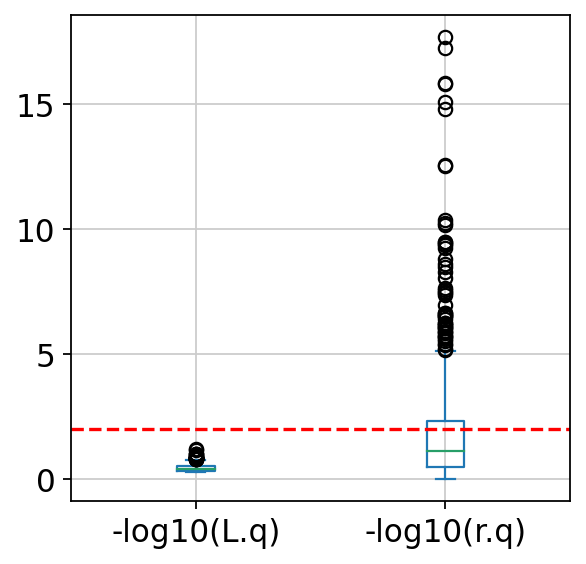

In [7]:
cc_prt.plot.box(column=['-log10(L.q)','-log10(r.q)'])
plt.axhline(y=2.0, color='r', linestyle='--')

In [8]:
cc_prt['dataset'] = 'SNARE-seq'
cc_prt.loc[:,['genes','peaks','L.FDR','r.FDR','dataset']].to_csv('results/SNARE_mousebrain.cc_pvalue.csv',index=False)